
### Imports

In [1]:
%pylab inline
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


### Options

In [37]:
Nside = 128
lmax = 3*Nside-1
print("lmax: %d"%lmax)

# Binning parameters
dl = 10 # bin width
Nl = 10 # number of bins
min_l = 2 # minimum l
print("binned lmax: %d"%(min_l+dl*Nl))

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

lmax: 383
binned lmax: 102


### Fiducial Power and Noise Spectrum
- Define some $C_\ell$ and $N_\ell$. This is just used to create a synthetic map for testing, and for weighting the data.

In [38]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)
l_arr,m_arr = healpy.Alm.getlm(lmax)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))

# Interpolate to all ell, m grid
Cl_th_interp = InterpolatedUnivariateSpline(l,Cl_th)
Nl_th_interp = InterpolatedUnivariateSpline(l,Nl_th)
Cl_th_lm = Cl_th_interp(l_arr)
Nl_th_lm = Nl_th_interp(l_arr)

# Zero out ell = 0 and ell = 1
Cl_th_lm[l_arr<2] = 0.
Nl_th_lm[l_arr<2] = 0.

### Synthetic Bispectrum
- Define a synthetic bispectrum. Here, this takes the form $b(\ell_1)b(\ell_2)b(\ell_3)$, where $b(\ell)$ is specified below. Maps will be generated with this bispectrum.
- Note we use the convention
$$\langle a_{\ell_1m_1}a_{\ell_2m_2}a_{\ell_3m_3}a_{\ell_4m_4}\rangle = \mathcal{G}^{\ell_1\ell_2\ell_3}_{m_1m_2m_3}b_{\ell_1\ell_2\ell_3},$$
where $b_{\ell_1\ell_2\ell_3}$ is the signal we're interested in and $\mathcal{G}$ is the Gaunt integral.

In [39]:
# define separable reduced bispectrum input
include_synthetic_b = True
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

### Load mask
- We use a Planck galaxy map here for testing.

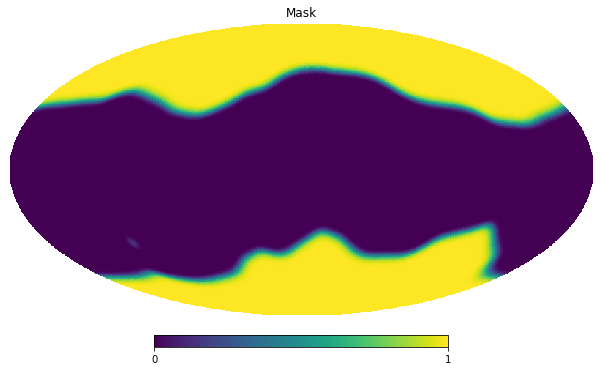

In [40]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Generate Synthetic Data with known $C_\ell$, $b_{\ell_1\ell_2\ell_3}$

**Bispectrum generation**
From Smith & Zaldarriaga (2006):
$$a_{\ell m} \to a_{\ell m}+\frac{1}{3}\nabla_{\ell m}T[C^{-1}_\ell a_{\ell m}]$$
with $\nabla_{\ell m}T[x]$ defined by
\begin{eqnarray}
    \frac{\partial T[a]}{\partial a^*_{\ell m}}&=&\frac{1}{2}b_{\ell\ell_2\ell_3}\mathcal{G}^{\ell\ell_2\ell_3}_{mm_2m_3}a_{\ell_2m_2}^*a_{\ell_3m_3}^*\\
    &=&\frac{1}{2}b_{\ell\ell_2\ell_3}\int d\hat{n} Y^*_{\ell m}(\hat n)Y^*_{\ell_2m_2}(\hat n)Y^*_{\ell_3m_3}(\hat n)a_{\ell_2m_2}^*a_{\ell_3m_3}^*
\end{eqnarray}
Assuming separable $b_{\ell_1\ell_2\ell_3}$, we can write
\begin{eqnarray}
    \frac{\partial T[a]}{\partial a^*_{\ell m}}&=&\frac{1}{2}b^{(1)}_{\ell}\left[[b^{(2)}a]^*(\hat n)[b^{(3)}a]^*(\hat n)\right]_{\ell m}
\end{eqnarray}
where $[b^{(i)}a](\hat n)$ is real. Notably, this does not satisfy $\langle{a_{\ell m}}\rangle = 0$; in practice, we subtract off a (deterministic) offset to ensure that this condition is obeyed.

In [41]:
# Basic HEALPix utilities
def to_lm(input_map):
    """Convert from map-space to harmonic-space"""
    return healpy.map2alm(input_map,pol=False)

def to_map(input_lm):
    """Convert from harmonic-space to map-space"""
    return healpy.alm2map(input_lm,Nside,pol=False)

def safe_divide(x,y):
    """Function to divide maps without zero errors."""
    out = np.zeros_like(x)
    out[y!=0] = x[y!=0]/y[y!=0]
    return out
    
def generate_data(seed=None,add_B=True,remove_mean=True):
    """Generate a cmb map with a given C_ell and (optionally) b_l1l2l3. 
    
    We use the method of Smith & Zaldarriaga 2006, and assume that b_l1l2l3 is separable into three identical pieces.
    
    We optionally subtract off the mean of the map (numerically, but could be done analytically), since it is not guaranteed to be zero if we include a synthetic bispectrum.
    
    No mask is added at this stage."""
    if seed!=None:
        np.random.seed(seed)
    
    # Generate a_lm
    initial_lm = healpy.synalm(Cl_th+Nl_th,lmax)
    
    if not add_B:
        return to_map(initial_lm)
    
    Cinv_lm = safe_divide(initial_lm,Cl_th_lm+Nl_th_lm)
    bCinv_map = to_map(b_input_fac(l_arr)*Cinv_lm)
    grad_lm = 0.5*b_input_fac(l_arr)*to_lm(bCinv_map*bCinv_map)
    
    output_lm = initial_lm + 1./3.*grad_lm
    output_map = to_map(output_lm)
    
    if remove_mean:
        output_map -= map_offset
        
    return output_map

# Compute mean of synthetic maps numerically
print("Computing offset for synthetic maps")
map_offset = 0.
N_norm = 100
for ii in range(N_norm):
    map_offset += generate_data(int(1e6)+ii,add_B=True,remove_mean=False)/N_norm

Computing offset for synthetic maps


### Generate Synthetic Data

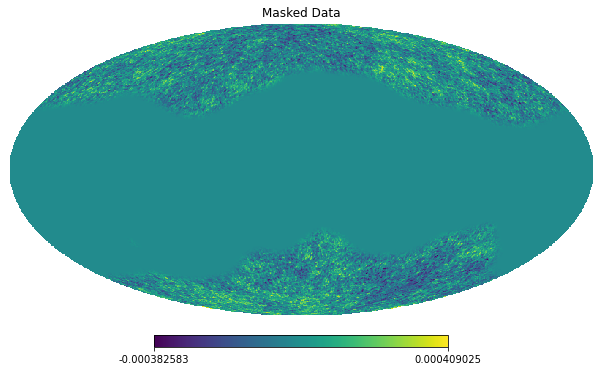

In [42]:
# Generate unmasked data
raw_data = generate_data(add_B=include_synthetic_b)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

In [43]:
av_sq_mask = np.mean(mask**2)
A_pix = 4.*np.pi/len(mask)
    
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular (C_l + N_l) and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    
    return Cinv_map

# Binned bispectrum estimation

### Conventional (binned) estimator
- We define the maps $$I_b(\hat n) = \int Y_{\ell m}^*(\hat n)\frac{a_{\ell m}}{C_\ell}\Theta_\ell(b)$$
where we weight the data by $C_{\ell}^{-1}$ (including noise spectra), and select the bin with $\Theta_\ell(b)$ which is $1$ if $\ell$ is in bin $b$ and zero else.
- The full binned bispectrum is given by
$$b_{b_1b_2b_3} \propto \frac{1}{\Delta_{b_1b_2b_3}}\int d\hat n\,I_{b_1}(\hat n)I_{b_2}(\hat n)I_{b_3}(\hat n),$$
where $\Delta_{b_1b_2b_3}$ is a symmetry factor, equal to $6$ if $b_1=b_2=b_3$, $2$ if $b_1=b_2$ (and similar) or one else. Note that we assert $b_3\geq b_2\geq b_1$.
- We also divide by $\langle{W^3\rangle}$ to remove the lowest-order effects of the mask.

In [44]:
# Define ell bins
ell_bins = [(l_arr>=min_l+dl*bin1)&(l_arr<min_l+dl*(bin1+1)) for bin1 in range(Nl)]

# Compute I maps
I_map = [to_map(ell_bins[bin1]*safe_divide(to_lm(data),Cl_th_lm+Nl_th_lm)) for bin1 in range(Nl)]

def check_bin(bin1,bin2,bin3):
    """Return one if modes in the bin satisfy the even-parity triangle conditions, or zero else.
    
    This is used either for all triangles in the bin, or just the center of the bin.
    """

    l1 = min_l+(bin1+0.5)*dl
    l2 = min_l+(bin2+0.5)*dl
    l3 = min_l+(bin3+0.5)*dl
    if l3<abs(l1-l2) or l3>l1+l2:
        return 0
    else:
        return 1

# Combine to find numerator
b_num_ideal = []
sym_factor = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not check_bin(bin1,bin2,bin3): continue
                
            # compute symmetry factor
            if bin1==bin2 and bin2==bin3:
                sym = 6
            elif bin1==bin2 or bin2==bin3:
                sym = 2
            else:
                sym = 1
            sym_factor.append(sym)
                
            # compute numerators
            b_num_ideal.append(A_pix*np.sum(I_map[bin1]*I_map[bin2]*I_map[bin3])/sym)        
            
b_num_ideal = np.asarray(b_num_ideal)/np.mean(mask**3)
            
# number of bins
N_b = len(b_num_ideal)
print("%d bispectrum bins"%N_b)

125 bispectrum bins


### Compute denominator 
- The estimator denominator is equal to the variance of the estimator (roughly, neglecting masking considerations).
- This is given by
$$F_{b_1b_2b_3} = \frac{1}{\Delta_{b_1b_2b_3}}\sum_{\ell_1\ell_2\ell_3}\frac{1}{4\pi}\begin{pmatrix}\ell_1 & \ell_2 & \ell_3\\ 0 & 0 & 0\end{pmatrix}^2\frac{(2\ell_1+1)(2\ell_2+1)(2\ell_3+1)}{C_{\ell_1}C_{\ell_2}C_{\ell_3}}$$
- We precompute the $3j$ symbols in Julia for speed (also possible to do in Python using the ```pywigxjpf``` package - much faster than sympy!)
- With a window, the variance is inflated modified by a factor $\langle{W^6\rangle}/\langle{W^3\rangle}^2$ (at lowest order).

In [45]:
# Load pre-computed 3j symbols
assert lmax<=500, "Higher-l 3j symbols not yet precomputed!"
tj_arr = np.load('/projects/QUIJOTE/Oliver/wig3j_array.npz')

# C+N vector
Sl_vec = [(li>=2)*(Cl_th_interp(li)+Nl_th_interp(li)) for li in l]

# compute denominator
b_denom = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not check_bin(bin1,bin2,bin3): continue
                
            if (len(b_denom)+1)%25==0: print("Computing bin %d of %d"%(len(b_denom)+1,N_b))
            value = 0.
            
            # Now iterate over l bins
            for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):
                for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):
                    for l3 in range(min_l+bin3*dl,min_l+(bin3+1)*dl):
                        if (-1)**(l1+l2+l3)==-1: continue # 3j = 0 here
                        if l3<abs(l1-l2) or l3>l1+l2: continue
                        tj = tj_arr[l1,l2,l3]
                        value += tj**2*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)/(4.*np.pi)/Sl_vec[l1]/Sl_vec[l2]/Sl_vec[l3]/sym_factor[len(b_denom)]
            b_denom.append(value)
b_denom = np.asarray(b_denom)

b_ideal = b_num_ideal/b_denom

Computing bin 25 of 125
Computing bin 50 of 125
Computing bin 75 of 125
Computing bin 100 of 125
Computing bin 125 of 125


### Plot the bispectra
- Here we'll plot everything collapsed down into one dimension. This isn't super interpretable but is a useful estimate.
- Let's compare the measured bispectra against the theory model.

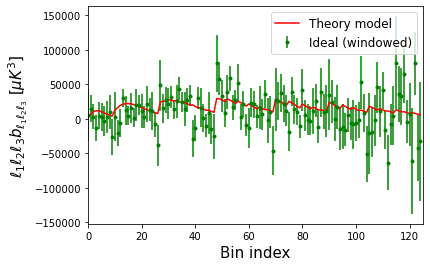

In [46]:
weights = []
bl_model = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not check_bin(bin1,bin2,bin3): continue
            weights.append((min_l+(bin1+0.5)*dl)*(min_l+(bin2+0.5)*dl)*(min_l+(bin3+0.5)*dl)*1e18)
            bl_model.append(b_input_fac(min_l+(bin1+0.5)*dl)*b_input_fac(min_l+(bin2+0.5)*dl)*b_input_fac(min_l+(bin3+0.5)*dl))
weights = np.asarray(weights)
bl_model = np.asarray(bl_model)
            
fish_err_ideal = np.sqrt(1./b_denom)
fish_err = np.sqrt(1./b_denom/np.mean(mask**3)**2*np.mean(mask**6))

plt.errorbar(np.arange(N_b),weights*b_ideal,yerr=weights*fish_err,marker='.',ls='',label='Ideal (windowed)',c='g')
plt.plot(np.arange(N_b),weights*bl_model,label='Theory model',c='r')
plt.xlim([0,N_b])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

### Repeat for multiple data-sets to check accuracy

In [47]:
b_ests = []
N_sim = 100
for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    raw_data = generate_data(jj,include_synthetic_b)

    # Mask the map
    data = raw_data*mask
    
    # Compute ideal estimator
    I_map = [to_map(ell_bins[bin1]*safe_divide(to_lm(data),Cl_th_lm+Nl_th_lm)) for bin1 in range(Nl)]
    
    # Combine to find numerator
    this_b_num_ideal = []
    for bin1 in range(Nl):
        for bin2 in range(bin1,Nl):
            for bin3 in range(bin2,Nl):
                # skip bins outside the triangle conditions
                if not check_bin(bin1,bin2,bin3): continue

                # compute numerators
                this_b_num_ideal.append(A_pix*np.sum(I_map[bin1]*I_map[bin2]*I_map[bin3])/sym_factor[len(this_b_num_ideal)])
    
    b_ests.append(np.asarray(this_b_num_ideal)/b_denom/np.mean(mask**3))

Analyzing simulation 1 of 100
Analyzing simulation 11 of 100
Analyzing simulation 21 of 100
Analyzing simulation 31 of 100
Analyzing simulation 41 of 100
Analyzing simulation 51 of 100
Analyzing simulation 61 of 100
Analyzing simulation 71 of 100
Analyzing simulation 81 of 100
Analyzing simulation 91 of 100


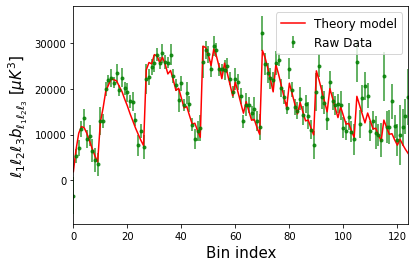

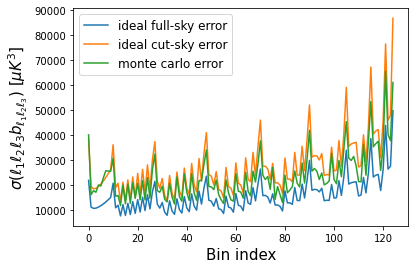

In [50]:
plt.plot(np.arange(N_b),weights*bl_model,label='Theory model',c='r')
plt.errorbar(np.arange(N_b),weights*np.asarray(b_ests).mean(axis=0),yerr=weights*np.asarray(b_ests).std(axis=0)/np.sqrt(len(b_ests)),
             ls='',marker='.',label='Raw Data',alpha=0.8,c='g')
plt.xlim([0,N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

plt.figure()
plt.plot(np.arange(N_b),weights*fish_err_ideal,label=r'ideal full-sky error')
plt.plot(np.arange(N_b),weights*fish_err,label=r'ideal cut-sky error')
plt.plot(np.arange(N_b),weights*np.asarray(b_ests).std(axis=0),label='monte carlo error')
plt.xlabel(r'Bin index',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);